In [1]:
#!pip install prysm
!pip install rayoptics

In [2]:
#import prysm
import rayoptics

In [3]:
# use standard rayoptics environment
from rayoptics.environment import *

# util functions
from rayoptics.util.misc_math import normalize

In [5]:
from ray_optics_criteria_ITMO import calc_loss

Create a new, empty, model

In [184]:
opm = OpticalModel() # create new model
#opm = open_model('test.roa') # load model from file

sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

Enter System related attributes

In [185]:
opm.system_spec.title = 'Test Model'
opm.system_spec.dimensions = 'mm'

Specify aperture, field, and wavelengths


In [186]:
# pupil - размер входного зрачка (диафрагмы)
osp['pupil'] = PupilSpec(osp, value=2.5)

# field of view - 'flds' - список точек поля (??), 'value' - maximum field, per the key (?)
# в 'flds' перечислены углы отклонения пучков от оси, по которым мы потом оцениваем качество фокуса на экране
# для лидерборда углы могут меняться
osp['fov'] = FieldSpec(osp, value=0.0, is_relative=True, flds=[0., 5.0, 10.0, 15.0, 20.0])

# задаём входной диапазон длин волн, нм
osp['wvls'] = WvlSpec([(470, 1.0), (650, 1.0)], ref_wl=1)

Test .roa file params

In [ ]:
osp.listobj_str()

'aperture: object pupil; value=2.5\nfield: object angle; value=0.0\nx,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000\ny=5.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=10.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=15.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=20.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ncentral wavelength=650.0 nm\nwavelength (weight) =  470.0000 (1.000),  650.0000 (1.000)*\nfocus shift=0.0\n'

Created schema params

In [167]:
osp.listobj_str()

'aperture: object pupil; value=2.5\nfield: object angle; value=0.0\nx,y=0.0 vlx= 0.000 vux= 0.000 vly= 0.000 vuy= 0.000\ny=5.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=10.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=15.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ny=20.0 vly= 0.000 vuy= 0.000 vlx= 0.000 vux= 0.000\ncentral wavelength=650.0 nm\nwavelength (weight) =  470.0000 (1.000),  650.0000 (1.000)*\nfocus shift=0.0\n'

Define interface and gap data for the sequential model

Test Schema from .roa

In [99]:
sm.listobj_str()

'0: Obj: dummy\nprofile: Spherical\nc=0.0,   r=0.0\nsurface_od=0\nradius=0.0\nt=10000000000.0 (+1);    medium: air\n\n1 (stop): transmit\nprofile: EvenPolynomial\nc=0.2747823174694503,   r=3.639244363353831   conic cnst=0.0\ncoefficients: [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]\nsurface_od=1.3159821701196845\nradius=1.3159821701196845\nt=1.0 (+1);    medium: 540.750, user\n\n2: transmit\nprofile: EvenPolynomial\nc=0.13556582944950138,   r=7.376490108611791   conic cnst=0.0\ncoefficients: [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]\nsurface_od=1.4607610829755018\nradius=1.4607610829755018\nt=0.5 (+1);    medium: air\n\n3: transmit\nprofile: EvenPolynomial\nc=-0.055209803982245384,   r=-18.112725057339173   conic cnst=0.0\ncoefficients: [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]\nsurface

In [102]:
sm.list_elements()

EvenPolynomial 0.2747823174694503 0.0 EvenPolynomial 0.13556582944950138 0.0 Gap(t=1.0, medium=ModelGlass(nd=1.54, vd=75.0, mat='540.750', cat='user'))
EvenPolynomial -0.055209803982245384 0.0 Spherical -0.2568888474926888 Gap(t=1.0, medium=ModelGlass(nd=1.67, vd=39.0, mat='670.390', cat='user'))


In [110]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      0.0000
 Stop:     0.274782      1.00000   540.750             1      1.3160
    2:     0.135566     0.500000       air             1      1.4608
    3:    -0.055210      1.00000   670.390             1      1.4312
    4:    -0.256889      4.21639       air             1      1.6088
  Img:     0.000000      0.00000                       1      1.8364


Created Schema

В первой строчке осталось surface_od=1.0, хотя в оригинале = 0. Сразу после этого в оригинале идёт "radius=0.0", а в созданной этого нет. В первой поверхности также в оригинале есть "radius=1.3159821701196845", а в созданной - нет - так во всех поверхностях.

In [176]:
sm.listobj_str()

'0: Obj: dummy\nprofile: Spherical\nc=0.0,   r=0.0\nsurface_od=1.0\nt=10000000000.0 (+1);    medium: air\n\n1 (stop): transmit\nprofile: EvenPolynomial\nc=0.2747823174694503,   r=3.639244363353831   conic cnst=0.0\ncoefficients: [0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]\nsurface_od=1.3159821701196845\nt=1 (+1);    medium: 540.750, user\n\n2: transmit\nprofile: EvenPolynomial\nc=0.13556582944950138,   r=7.376490108611791   conic cnst=0.0\ncoefficients: [0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]\nsurface_od=1.4607610829755018\nt=0.5 (+1);    medium: air\n\n3: transmit\nprofile: EvenPolynomial\nc=-0.055209803982245384,   r=-18.112725057339173   conic cnst=0.0\ncoefficients: [0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0]\nsurface_od=1.4312127337246845\nt=1 (+1);    medium: 670.390, user\n\n4: t

непонятно, откуда берутся коэффициенты (coefs) - их мы тоже подбираем при оптимизации

In [175]:
sm.list_elements()

EvenPolynomial 0.2747823174694503 0.0 EvenPolynomial 0.13556582944950138 0.0 Gap(t=1, medium=ModelGlass(nd=1.54, vd=75.0, mat='', cat='user'))
EvenPolynomial -0.055209803982245384 0.0 Spherical -0.2568888474926888 Gap(t=1, medium=ModelGlass(nd=1.67, vd=39.0, mat='', cat='user'))


In [187]:
#opm.radius_mode = True
sm.do_apertures = True


sm.gaps[0].thi=1e10


# [curvature, t, 1.('medium' до заяптой), medium (после запятой без нуля на конце)], sd это surface_od,
# 1 surface - lens
sm.add_surface([0.2747823174694503, 1, 1.540, 75.0], sd=1.3159821701196845)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=3.639244363353831,
                        coefs=[0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0])

sm.set_stop()
# 2 surface - air
sm.add_surface([0.13556582944950138, 0.5], sd=1.4607610829755018)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=7.376490108611791,
                        coefs=[0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0])

# 3 surface - lens
sm.add_surface([-0.055209803982245384, 1, 1.670, 39.0], sd=1.4312127337246845)
sm.ifcs[sm.cur_surface].profile = EvenPolynomial(r=-18.112725057339173,
                        coefs=[0.0, -0.0231369463217776, 0.011956554928461116, -0.017782670650182023, 0.004077846642272649, 0.0, 0.0, 0.0])

# 4 surface - air
sm.add_surface([-0.2568888474926888, 4.216392884493065], sd=1.608772352457493)


Update the model

In [188]:
opm.update_model()

Turn off automatically resizing apertures based on sequential model ray trace.



In [195]:
sm.do_apertures = False

List the sequential model and the first order properties

In [189]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      0.0000
 Stop:     0.274782      1.00000   540.750             1      1.2500
    2:     0.135566     0.500000       air             1      1.2128
    3:    -0.055210      1.00000   670.390             1      1.1203
    4:    -0.256889      4.21639       air             1      1.1021
  Img:     0.000000      0.00000                       1    0.030701


In [190]:
pm.first_order_data()

efl               5.194
ffl              -4.041
pp1               1.153
bfl               4.325
ppk              0.8686
f/#               2.078
m            -5.194e-10
red          -1.925e+09
obj_dist          1e+10
obj_ang               1
enp_dist             -0
enp_radius         1.25
na obj         1.25e-10
n obj                 1
img_dist          4.325
img_ht          0.09066
exp_dist         -2.242
exp_radius        1.607
na img           -0.234
n img                 1
optical invariant      0.02182


In [191]:
pt.list_model()

root
├── Object
├── E1
├── E2
└── Image


Draw a lens layout to verify the model

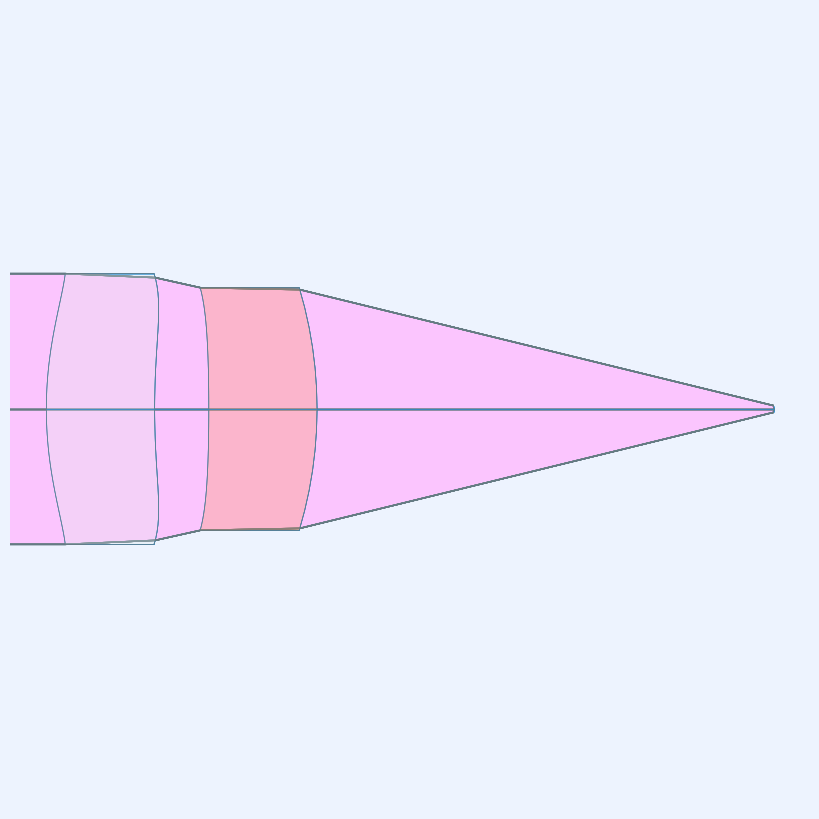

In [196]:
isdark = False

layout_plt0 = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        is_dark=isdark).plot()

Save Current model

In [197]:
opm.save_model('test_new.roa')

Calc loss metric for optic model

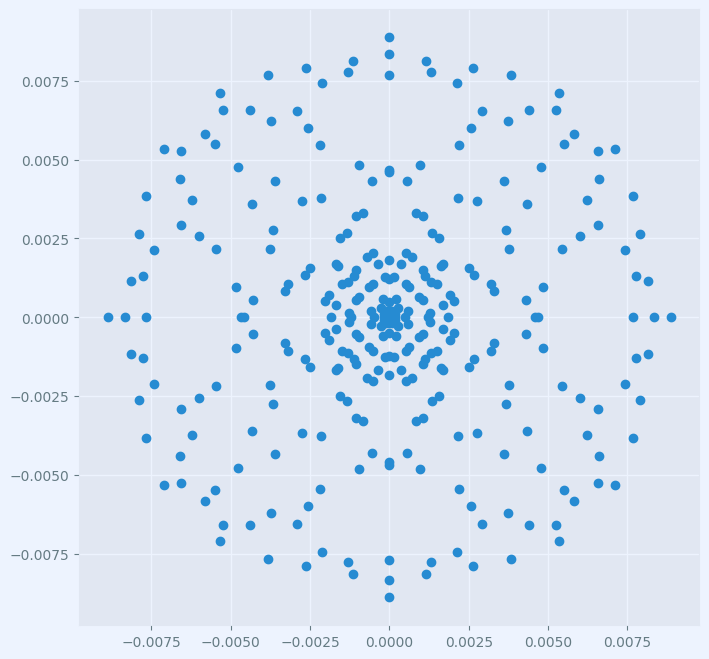

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      0.0000
 Stop:     0.274782      1.00000   540.750             1      1.2500
    2:     0.135566     0.500000       air             1      1.2128
    3:    -0.055210      1.00000   670.390             1      1.1203
    4:    -0.256889      4.21639       air             1      1.1021
  Img:     0.000000      0.00000                       1    0.030701
0 Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1 Surface(profile=EvenPolynomial(c=0.2747823174694503, cc=0.0, coefs=[0.0, 0.009109298409282469, -0.03374649200850791, 0.01797256809388843, -0.0050513483804677005, 0.0, 0.0, 0.0]), interact_mode='transmit')
2 Surface(profile=EvenPolynomial(c=0.13556582944950138, cc=0.0, coefs=[0.0, -0.002874728268075267, -0.03373322938525211, 0.004205227876537139, -0.0001705765222318475, 0.0, 0.0, 0.0]), interact_mode='transmit')
3 Surface(profile=EvenPolynomial(

11.793397793444745

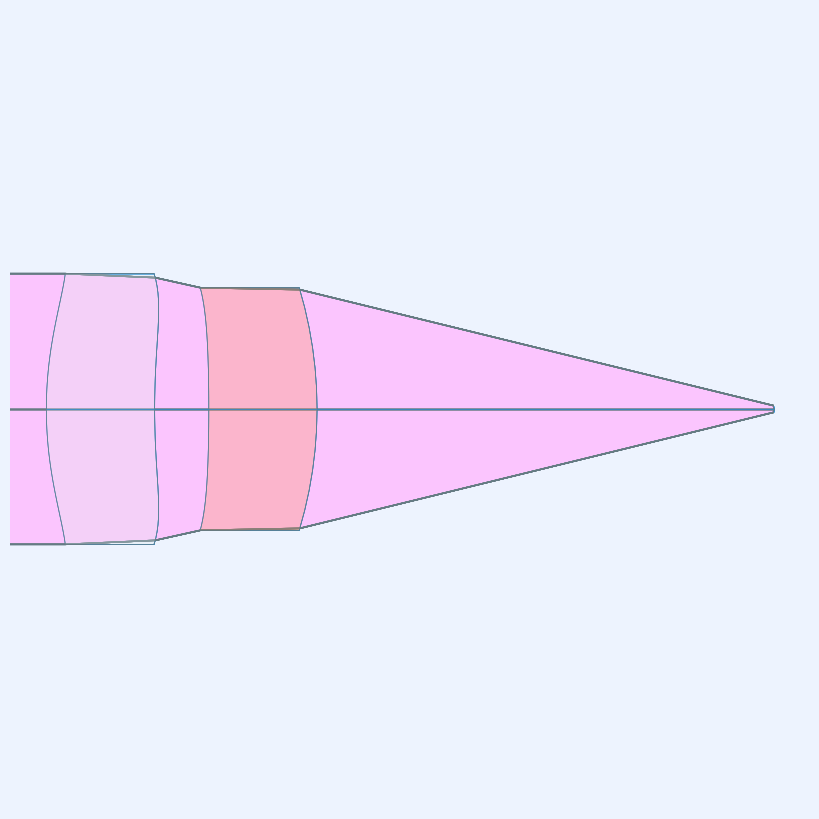

In [199]:
calc_loss('test_new.roa')

Note that in the lens layout above, the very aspheric surface shapes lead to extreme lens element shapes. The default logic used by ray-optics to apply flat bevels to concave surfaces is defeated by the aspherics that switch concavity between vertex and edge. How ray-optics renders flats can be controlled on a surface by surface basis.

First, generate a list of lens elements from the part tree.

In [25]:
elmn = [node.id for node in pt.nodes_with_tag(tag='#element')]

Lens elements have two surfaces, each of which can be specified with or without a flat.



In [45]:
elmn[0].sd

1.25

In [31]:
elmn[0].do_flat1 = 'always'
elmn[0].do_flat2 = 'always'

elmn[1].do_flat1 = 'always'
elmn[1].do_flat2 = 'always'
#elmn[2].do_flat1 = 'always'
#elmn[2].do_flat2 = 'always'
#elmn[3].do_flat1 = 'always'
#elmn[3].do_flat2 = 'always'



By default, the inside diameters of a flat are set to the clear aperture of the interface in the sequential model. This can be overriden for each surface. The semi-diameter sd() of the lens element may also be set explicitly.

In [36]:
elmn[0].sd = 1.25

elmn[1].sd = 1.75
elmn[1].flat1 = 1.25
elmn[1].flat2 = 1.645

'''
elmn[2].sd = 2.5
elmn[2].flat1 = 2.1

elmn[3].sd = 3.0
elmn[3].flat1 = 2.6

elmn[4].sd = 3.5
'''

'\nelmn[2].sd = 2.5\nelmn[2].flat1 = 2.1\n\nelmn[3].sd = 3.0\nelmn[3].flat1 = 2.6\n\nelmn[4].sd = 3.5\n'

Draw a lens layout to verify the model


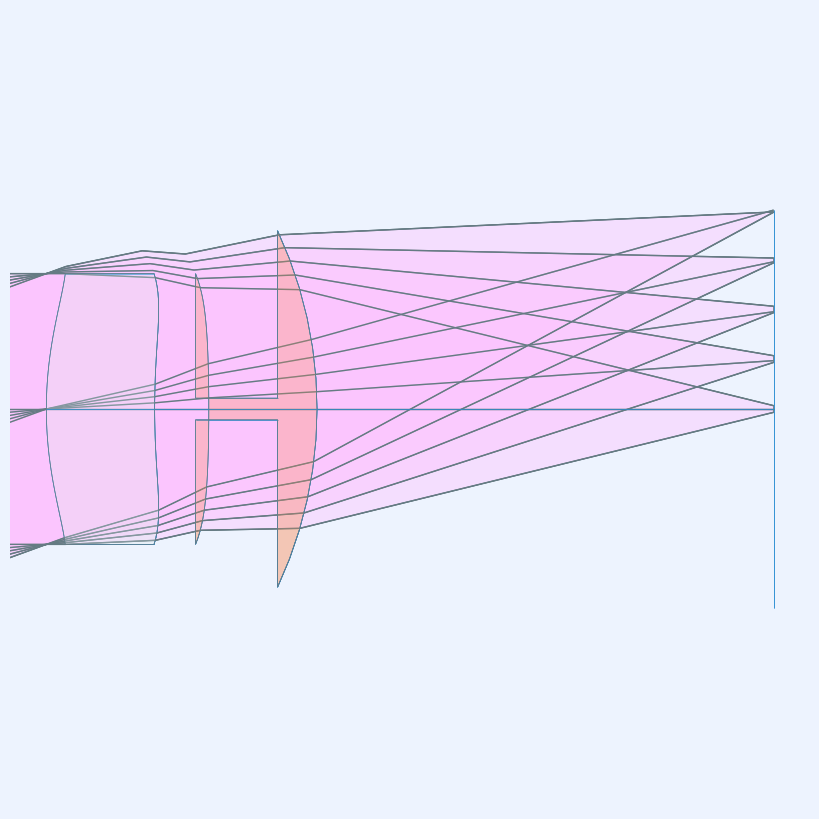

In [37]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        is_dark=isdark).plot()

Plot a Spot Diagram


  warnings.warn(msg, RuntimeWarning)



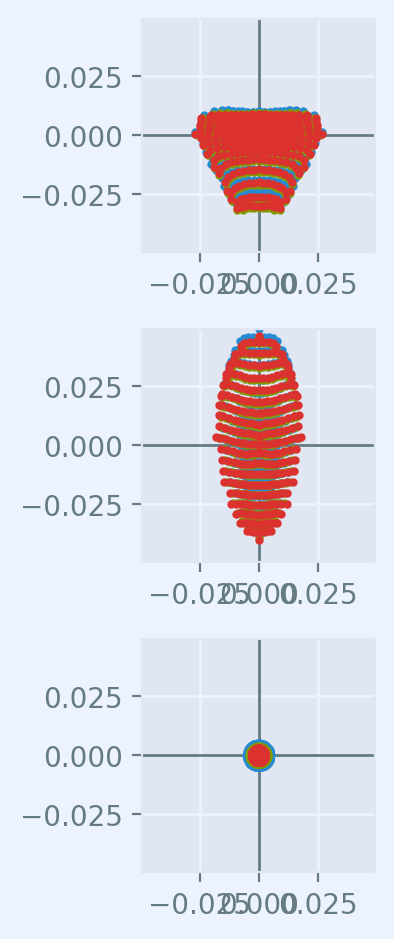

In [ ]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()

Third Order Seidel aberrations

In [ ]:
to_pkg = compute_third_order(opm)
to_pkg

,S-I,S-II,S-III,S-IV,S-V
1,-0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000
2,1.143048e-02,0.017805,0.027736,0.040799,0.106757
3,1.574912e-03,-0.006330,0.025442,-0.002397,-0.092626
4,-1.199125e-02,0.003986,-0.001325,-0.043099,0.014769
5,8.838856e-04,-0.002985,0.010081,0.014770,-0.083929
6,-4.437785e-06,0.000283,-0.018097,0.014829,0.208687
7,1.072426e-04,-0.001422,0.018849,-0.009186,-0.128105
8,-5.007645e-05,-0.001123,-0.025179,0.050440,0.566445
9,4.823567e-08,0.000052,0.055610,-0.055956,-0.370718
10,-1.956735e-04,0.001170,-0.006995,0.000000,0.041827


Bar chart for surface by surface third order aberrations


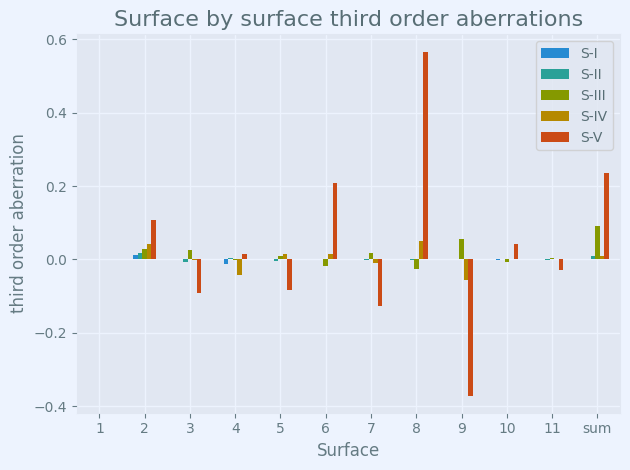

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Surface')
ax.set_ylabel('third order aberration')
ax.set_title('Surface by surface third order aberrations')
to_pkg.plot.bar(ax=ax, rot=0)
ax.grid(True)
fig.tight_layout()

convert aberration sums to transverse measure


In [ ]:
ax_ray, pr_ray, fod = ar['parax_data']
n_last = pm.sys[-1][mc.indx]
u_last = ax_ray[-1][mc.slp]
to.seidel_to_transverse_aberration(to_pkg.loc['sum',:], n_last, u_last)

TSA   -0.006611
TCO   -0.111704
TAS   -0.990128
SAS   -0.353845
PTB   -0.035704
DST   -0.820921
dtype: float64

convert sums to wavefront measure


In [ ]:
central_wv = opm.nm_to_sys_units(sm.central_wavelength())
to.seidel_to_wavefront(to_pkg.loc['sum',:], central_wv).T

W040      0.401816
W131      9.053036
W222     77.351443
W220     43.016183
W311    199.594945
dtype: float64